# Navigation

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
import time

%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
from sys import platform

if platform == "linux" or platform == "linux2":
    file = 'config/Banana_Linux_NoVis/Banana.x86_64'
elif platform == "darwin":
    file = 'config/Banana.app'

platform

'linux'

In [4]:
env = UnityEnvironment(file_name=file)

brain_name = env.brain_names[0]
print(brain_name)

brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


BananaBrain


In [5]:
env_info = env.reset(train_mode=True)[brain_name]

n_agents = len(env_info.agents)               # number of agents in the environment
action_size = brain.vector_action_space_size  # number of actions
state = env_info.vector_observations[0]       # examine the state space 
state_size = len(state)


print('Agents ', n_agents)
print('Actions ', action_size)
print('State ', state)
print('Len of State ', state_size)

Agents  1
Actions  4
State  [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
Len of State  37


## Watch untrained agent

In [6]:
see_untrain = True

In [7]:
env_info = env.reset(train_mode=True)[brain_name]

state = env_info.vector_observations[0]

score = 0

while see_untrain:
    action = np.random.randint(action_size)
    
    env_info = env.step(action)[brain_name]
    
    reward, next_state, done = \
        env_info.rewards[0], env_info.vector_observations[0], env_info.local_done[0]
    
    score += reward
    state = next_state
    
    if done:
        print('Mission Accomplished!')
        break
print('Score {}'.format(score))

Mission Accomplished!
Score 0.0


In [8]:
#env.close()

## Watch untrained agent - using DQN

In [9]:
from dqn_agent import Agent

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

In [10]:
env_info = env.reset(train_mode=True)[brain_name]

state = env_info.vector_observations[0]

score = 0

while see_untrain:
    
    action = agent.act(state)
    
    env_info = env.step(action)[brain_name]
    
    reward, state, done = \
        env_info.rewards[0], env_info.vector_observations[0], env_info.local_done[0]
    
    score += reward
    
    if done:
        print('Mission Accomplished!')
        break
        
print('Score {}'.format(score))

Mission Accomplished!
Score 2.0


## Train Agent

In [11]:
from collections import deque

train = False

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i in range(1,n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        
        for t in range(max_t):
            action = agent.act(state, eps)
            
            env_info = env.step(action)[brain_name]
            reward, next_state, done = \
                env_info.rewards[0], env_info.vector_observations[0], env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            
            if done:
                break
                
        scores.append(score)
        scores_window.append(score)
        
        eps = max(eps_end, eps * eps_decay)
        
        avg = np.mean(scores_window)
        
        print('\rEpisode: {} \t Avg Score: {:.2f}'.format(i, avg), end='')
        
        if i % 100 == 0:
            print('\rEpisode: {} \t Avg Score: {:.2f}'.format(i, avg))
            
        if np.mean(scores_window) >= 13.0:
            print('\r[Solved] Episodes {:d} Avg Score: {:.2f}'.format(i, avg))
            
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            
            with open('scores.pkl', 'wb') as fp:
                pickle.dump(scores, fp)
                        
            break
            
    return scores


if train:
    scores = dqn(n_episodes=1000)
else:
    print('Model Loaded')
    model = torch.load('checkpoint.pth', map_location=device)
    agent.qnetwork_local.load_state_dict(model)
    agent.qnetwork_target.load_state_dict(model)
    
    with open ('scores.pkl', 'rb') as fp:
        scores = pickle.load(fp)

Model Loaded


## Scores

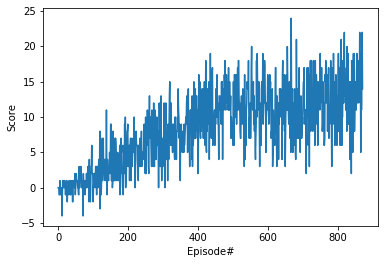

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(len(scores))
y = scores
plt.plot(x, y)
plt.xlabel('Episode#')
plt.ylabel('Score');

## Watch Trained Agent

In [13]:
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
score = 0

while True:
    
    action = agent.act(state)
    
    env_info = env.step(action)[brain_name]
    time.sleep(0.2)
    reward, state, done = \
        env_info.rewards[0], env_info.vector_observations[0], env_info.local_done[0]
    
    score += reward
    
    if done:
        print('Mission Accomplished!')
        break
        
print('Score {}'.format(score))

Mission Accomplished!
Score 11.0


In [14]:
env.close()
print('complete')

complete
